preprocessing 2

Sources:
https://prastuti.medium.com/twitter-sentiment-analysis-on-covid-19-using-vader-82f030b686a9
https://github.com/cjhutto/vaderSentiment
https://www.justintodata.com/twitter-sentiment-analysis-python/


In [2]:
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px



Extracting first tweets for sentiment analysis

In [3]:
tweetsDf = pd.read_csv("twitterDataOutput.csv")
print("dataframe shape: " + str(tweetsDf.shape) )

tweetsDf.head

dataframe shape: (448740, 3)


<bound method NDFrame.head of                             date                   id  \
0       2022-05-31T23:14:24.000Z  1531776135083720711   
1       2022-05-31T22:17:29.000Z  1531761813922136065   
2       2022-05-31T22:09:18.000Z  1531759753071845376   
3       2022-05-31T22:05:43.000Z  1531758850273050626   
4       2022-05-31T22:04:05.000Z  1531758441521467395   
...                          ...                  ...   
448735  2019-01-01T00:20:15.000Z  1079895037868232704   
448736  2019-01-01T00:19:16.000Z  1079894793583509507   
448737  2019-01-01T00:18:55.000Z  1079894704504913920   
448738  2019-01-01T00:16:20.000Z  1079894051745382410   
448739  2019-01-01T00:14:27.000Z  1079893578829230081   

                                                    tweet  
0       @FilipinoFollies It’s outdated. 3rd has negati...  
1       A Japan song title feeling very topical at the...  
2       @FurnaceFear @Jo_dB Although it cuts off befor...  
3       #Bradford is trending on @Twitter!   

In [4]:
htmlSymbols = {"&amp;": "and", "&quot;": '"', "&apos;": "'", "&cent;": "cent", "&pound;": "pound", "&yen;": "yen", "&euro;": "euro",
 "&copy;": "copyright", "&reg;": "registered trademark"}

In [5]:
def cleanTweet(tweet):
    # to lower case
    cleanTweet = tweet.lower()
    #removing leading and trailing whitespace
    cleanTweet = cleanTweet.strip()
    # remove whitespaces
    cleanTweet = ' '.join(cleanTweet.split())
    # remove user mentions
    cleanTweet = re.sub("(@[A-Za-z0-9_]+)","", cleanTweet)
    # remove urls
    cleanTweet = re.sub("https?://[A-Za-z0-9./]*","", cleanTweet)
    # replace common html symbols
    for key in htmlSymbols.keys():
        cleanTweet = cleanTweet.replace(key, htmlSymbols[key])
    return cleanTweet

In [6]:
tweetsDf['cleanTweet'] = tweetsDf['tweet'].apply(lambda x:cleanTweet(x))

In [7]:
pd. set_option('display.max_rows', 10)
pd. set_option('display.max_columns', None)
pd. set_option('display.width', None)
pd. set_option('display.max_colwidth', None)
tweetsDf

date                   id  \
0       2022-05-31T23:14:24.000Z  1531776135083720711   
1       2022-05-31T22:17:29.000Z  1531761813922136065   
2       2022-05-31T22:09:18.000Z  1531759753071845376   
3       2022-05-31T22:05:43.000Z  1531758850273050626   
4       2022-05-31T22:04:05.000Z  1531758441521467395   
...                          ...                  ...   
448735  2019-01-01T00:20:15.000Z  1079895037868232704   
448736  2019-01-01T00:19:16.000Z  1079894793583509507   
448737  2019-01-01T00:18:55.000Z  1079894704504913920   
448738  2019-01-01T00:16:20.000Z  1079894051745382410   
448739  2019-01-01T00:14:27.000Z  1079893578829230081   

                                                                                                                                                                                                                                                                                                                     tweet  \
0                                                                                                              @FilipinoFollies It’s outdated. 3rd has negative connotations like the Philippines is somehow in 3rd place, Filipinos are in fact winning, at least those Filipinos who are not negative like yourself sir.   
1                                                                                                                                                                                                           A Japan song title feeling very topical at the moment. So is the B-side unfortunately. https://t.co/OkAqdLGwxH   
2                                                                                                                                                      @FurnaceFear @Jo_dB Although it cuts off before my favourite line from Adolf Martin 'and you see, I think it all started going wrong when the Japanese arrived....'   
3       #Bradford is trending on @Twitter!   We have been waiting for #CityofCulture2025  It's our place &amp; our time   @FoxandWindmill the UK's first indie publisher for British South Asians is based right here in #Bradford and we'll always back our beautiful city as proud Bradfordians🦊 https://t.co/5bg3y8tXaN   
4                                                                                                                                                                                                      This was a light day in Vietnam back in my World At War days during game chat.   Sorry Kat. https://t.co/BHYEVC7jyL   
...                                                                                                                                                                                                                                                                                                                    ...   
448735                                                      Buy our oriental rugs on-line or visit our shop in the historic market town Olney, Buckinghamshire where there is so much more to see!   Visit https://t.co/biDiyKXjqF for more information.  #OlneyRugs, #AreaRug, #HandKnotted, #IranianRugs, #RectangleRugs   
448736                                                                                                                                                                                  So I'm at my parents house and someone has let off one of those chinese lanterns (picture isnt very clear) https://t.co/RwfcGMuwtj   
448737                                                                                                     Goodbye 2018 it was a great year but here's to an even more fabulous 2019 #kualalumpur #dubai #macau #china #paris #london #rydercup #illinoistech #chicago @ Cambridge, Cambridgeshire https://t.co/mixLaM9O7S   
448738                                                                                                  @Queen_UK Yes Ma’m... That display in Singapore looked more

In [8]:
# carrying out sentiment analysis using VADER on each cleanTweet
analyzer = SentimentIntensityAnalyzer()
tweetsDf['scores'] = tweetsDf['cleanTweet'].apply(lambda x: analyzer.polarity_scores(x))

In [9]:
# assinging a label: positive, negative, or neutral
def labelSentiment(scoreDictionary):
    compoundScore = scoreDictionary['compound']
    if compoundScore >= 0.05:
        return "positive"
    elif compoundScore <= -0.05:
        return "negative"
    else:
        return "neutral"

In [10]:
tweetsDf['label'] = tweetsDf['scores'].apply(lambda x: labelSentiment(x))

In [11]:
positiveTweets = tweetsDf[tweetsDf['label'] == 'positive']
negativeTweets = tweetsDf[tweetsDf['label'] == 'negative']
neutralTweets = tweetsDf[tweetsDf['label'] == 'neutral']

print("number of positive tweets: " + str(positiveTweets.shape[0]))
print("number of negative tweets: " + str(negativeTweets.shape[0]))
print("number of neutral tweets: " + str(neutralTweets.shape[0]))

number of positive tweets: 229672
number of negative tweets: 118428
number of neutral tweets: 100640


[Text(0.5, 1.0, 'Number of positive, negative, and neutral tweets using VADER')]

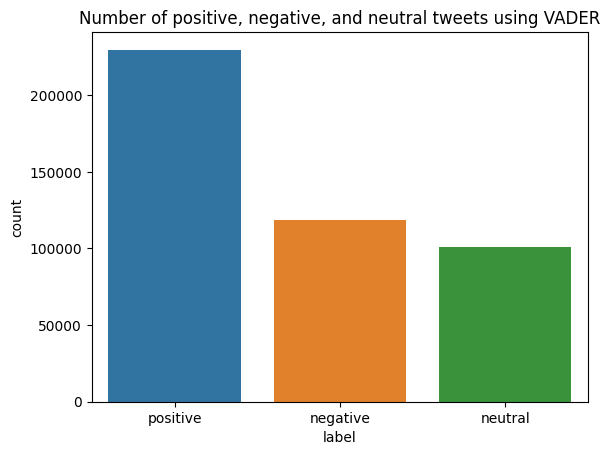

In [12]:
sns.countplot(x=tweetsDf['label'], label= 'count').set(title='Number of positive, negative, and neutral tweets using VADER')

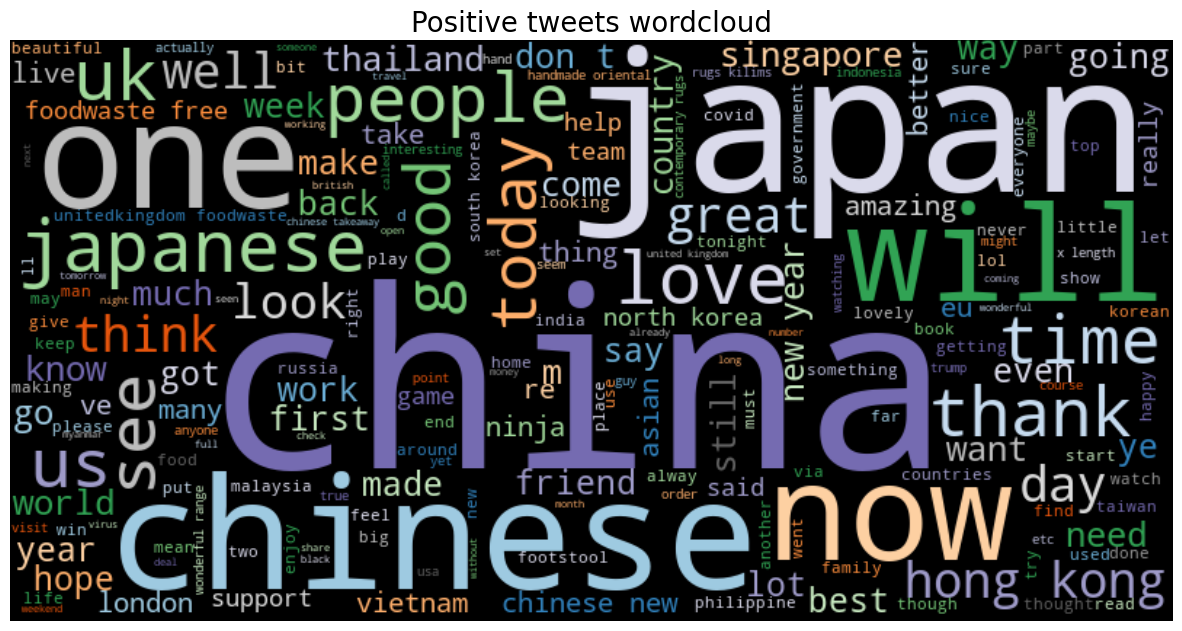

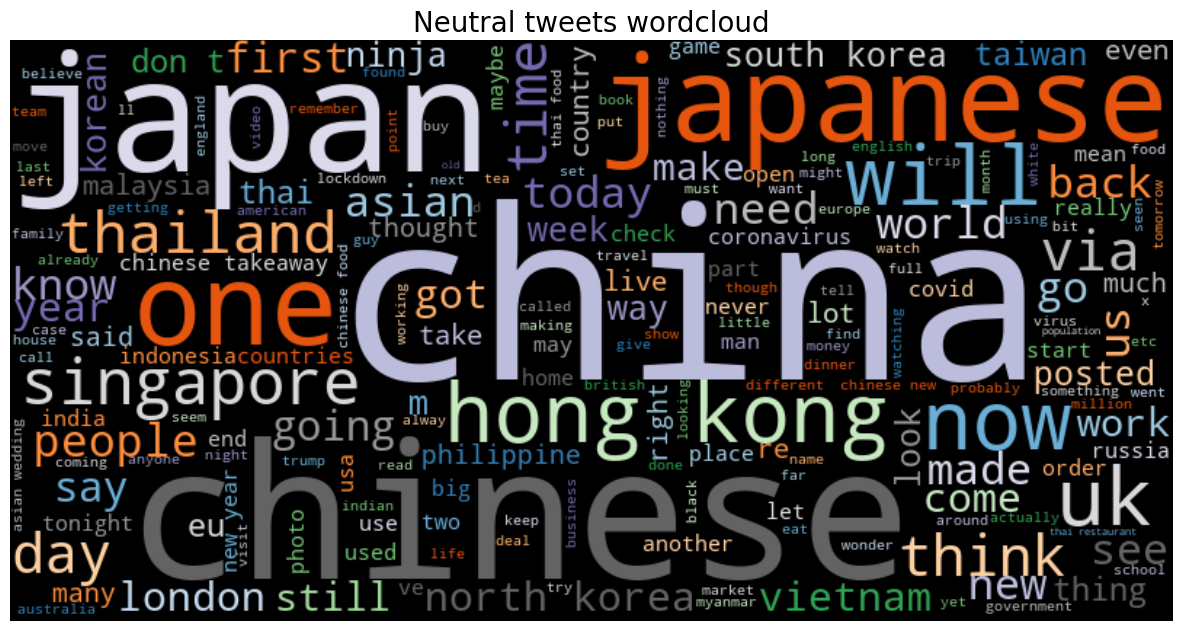

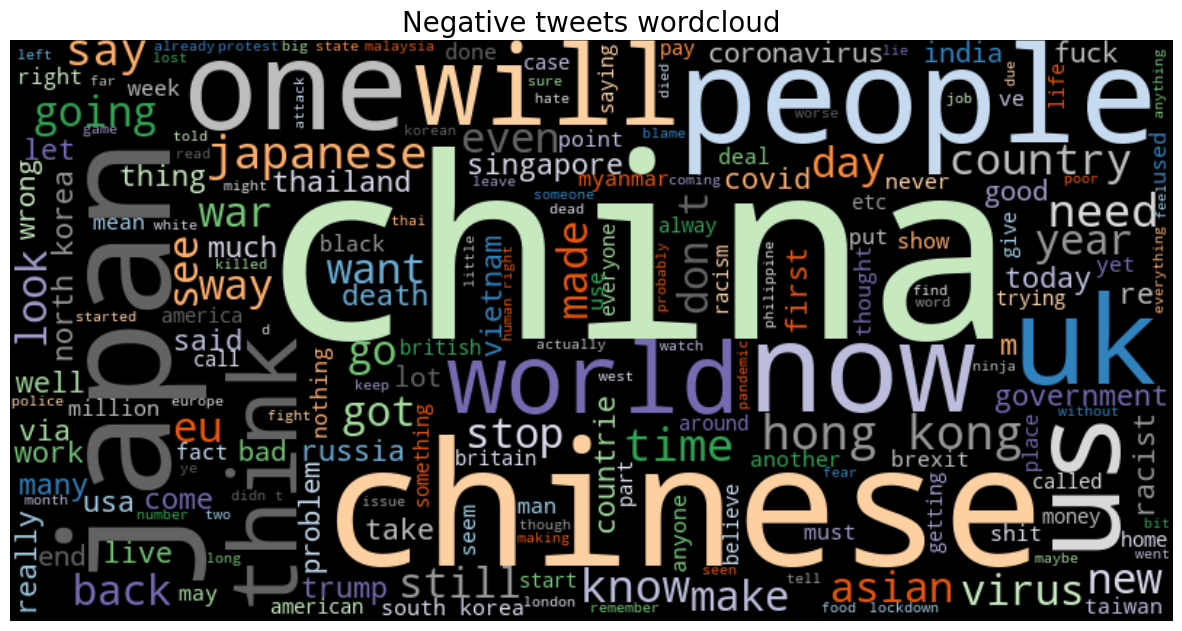

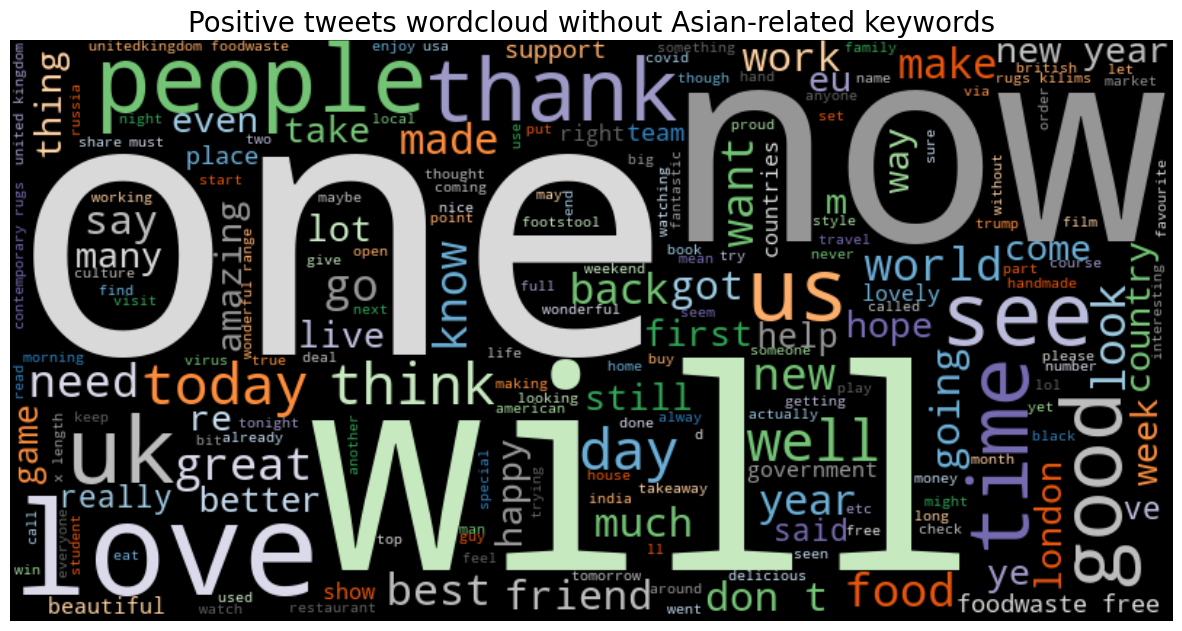

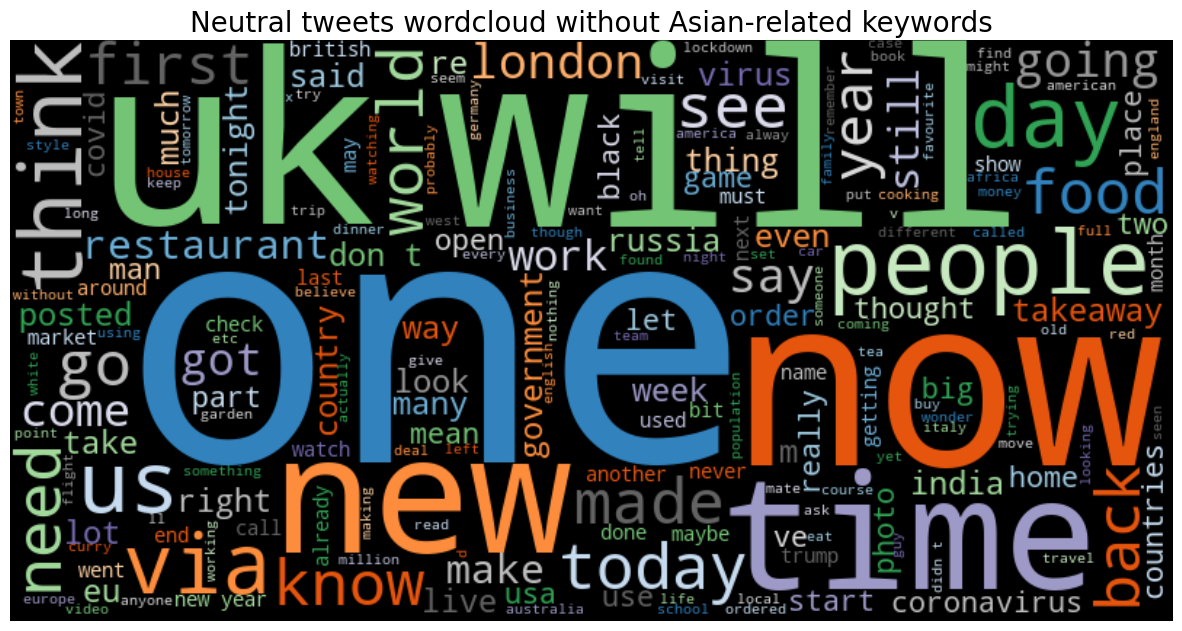

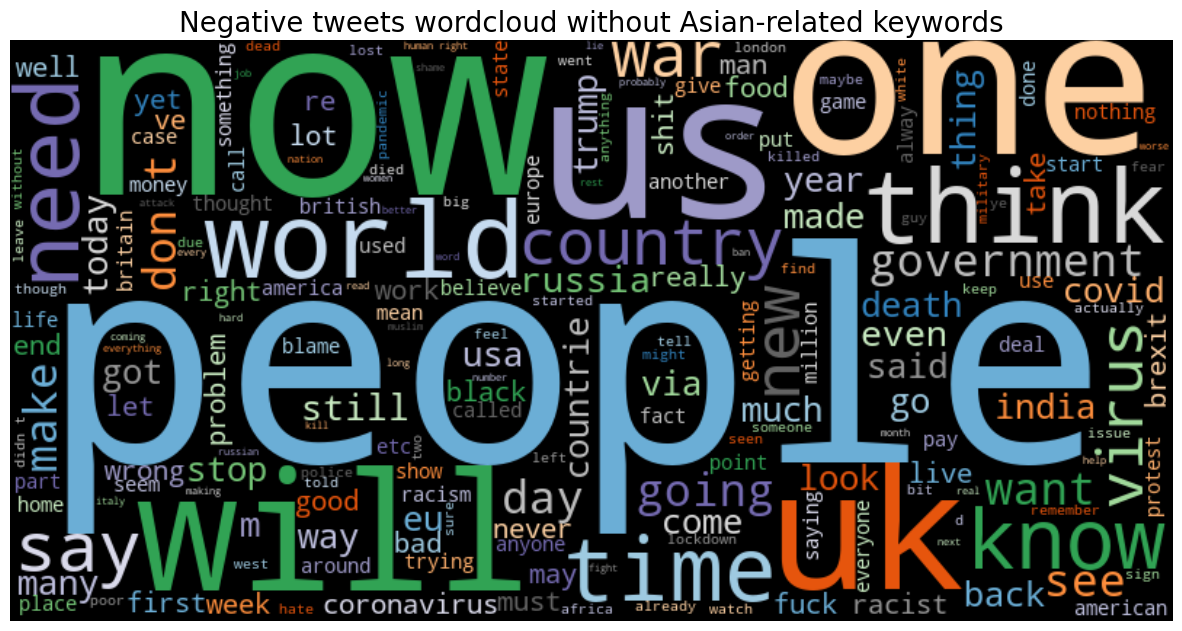

In [15]:
stops = set(STOPWORDS)
stops.add("U")
stops.add("S")

def tweetsDfToWC(df, title, stopwordSet):
    tweets_list = df['cleanTweet'].tolist()
    tweets_string = " ".join(tweets_list)
    wc = WordCloud(width=800, height=400, background_color='black', colormap='tab20c', stopwords=stopwordSet).generate(tweets_string)
    plt.figure(figsize = (15,15))
    plt.title(title, fontsize = 20)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
   
tweetsDfToWC(positiveTweets, "Positive tweets wordcloud", stops)
tweetsDfToWC(neutralTweets, "Neutral tweets wordcloud", stops)
tweetsDfToWC(negativeTweets, "Negative tweets wordcloud", stops)

keyWordData = pd.read_csv('finalAsianKeywords.csv')
keywordList = keyWordData['keyword'].tolist()
for word in keywordList:
    if " " in word:
        words = word.split()
        for newWord in words:
            keywordList.append(newWord)
keywordSet = set(keywordList)
stopwordsKeywordSet = keywordSet.union(stops)

tweetsDfToWC(positiveTweets, "Positive tweets wordcloud without Asian-related keywords", stopwordsKeywordSet)
tweetsDfToWC(neutralTweets, "Neutral tweets wordcloud without Asian-related keywords", stopwordsKeywordSet)
tweetsDfToWC(negativeTweets, "Negative tweets wordcloud without Asian-related keywords", stopwordsKeywordSet)


In [13]:
def floorDate(dateString):
    shortDateStr = dateString[:10]
    shortDateFormat = "%Y-%m-%d"
    return datetime.strptime(shortDateStr, shortDateFormat)

tweetsDf['day'] = tweetsDf['date'].apply(lambda x: floorDate(x))

In [14]:
aggregate = {'cnt': ('id', 'count')}
sentimentOverTimeDf = tweetsDf.groupby(['day', 'label']).agg(**aggregate).reset_index()
sentimentOverTimeDf


day     label  cnt
0    2019-01-01  negative  107
1    2019-01-01   neutral   87
2    2019-01-01  positive  226
3    2019-01-02  negative  102
4    2019-01-02   neutral  128
...         ...       ...  ...
3736 2022-05-30   neutral   55
3737 2022-05-30  positive  107
3738 2022-05-31  negative   50
3739 2022-05-31   neutral   52
3740 2022-05-31  positive   97

[3741 rows x 3 columns]

In [15]:
fig = px.line(sentimentOverTimeDf, x='day', y='cnt', color='label', title = "VADER sentiment analysis of UK-based Asia-related tweets Jan 2019 - Jun 2022", width=1800, height=600,

labels={
                     "day": "Date",
                     "cnt": "Number of tweets"
                 },
             color_discrete_map={ # replaces default color mapping by value
                "negative":  '#EF553B', "neutral": '#FECB52', "positive": '#00CC96'
            }
)
           
fig.show()

**Negative tweets as a proportion of total tweets**

In [16]:
negativeSentimentProportionDf = tweetsDf.groupby(['day']).agg(**aggregate).reset_index()
negativeSentimentProportionDf.rename(columns={'cnt': 'totalTweetsCnt'}, inplace=True)
negativeSentimentProportionDf.head()



day  totalTweetsCnt
0 2019-01-01             420
1 2019-01-02             473
2 2019-01-03             633
3 2019-01-04             478
4 2019-01-05             421

In [17]:

def getSentimentLabelCount(day, sentimentStr):
    #day is a date string corresponding to format: 2019-01-01
    subDf = sentimentOverTimeDf.loc[(sentimentOverTimeDf['day'] == day) & (sentimentOverTimeDf['label'] == sentimentStr)]
    return subDf.iloc[0]['cnt']

negativeSentimentProportionDf['negativeCnt'] = negativeSentimentProportionDf['day'].apply(lambda x: getSentimentLabelCount(x, "negative"))
negativeSentimentProportionDf['percentNegative'] = (negativeSentimentProportionDf["negativeCnt"] / negativeSentimentProportionDf["totalTweetsCnt"]) * 100
negativeSentimentProportionDf.head()



day  totalTweetsCnt  negativeCnt  percentNegative
0 2019-01-01             420          107        25.476190
1 2019-01-02             473          102        21.564482
2 2019-01-03             633          161        25.434439
3 2019-01-04             478          116        24.267782
4 2019-01-05             421           97        23.040380

In [18]:
fig = px.line(negativeSentimentProportionDf, x='day', y='percentNegative', title = "VADER sentiment analysis of UK-based Asia-related tweets Jan 2019 - Jun 2022: Negative tweets as a percentage of total tweets collected", width=1800, height=600,

labels={
                     "day": "Date",
                     "percentNegative": "Percentage of Tweets that are Negative"
                 },
             color_discrete_map={ # replaces default color mapping by value
                "percentNegative":  '#EF553B'
            }
)

fig.update_traces(line_color='brown')
           
fig.show()

In [19]:
negativeSentimentProportionDf['week'] = pd.to_datetime(negativeSentimentProportionDf["day"]).dt.to_period('W-SUN').dt.start_time
negativeSentimentProportionDf.head(20)

day  totalTweetsCnt  negativeCnt  percentNegative       week
0  2019-01-01             420          107        25.476190 2018-12-31
1  2019-01-02             473          102        21.564482 2018-12-31
2  2019-01-03             633          161        25.434439 2018-12-31
3  2019-01-04             478          116        24.267782 2018-12-31
4  2019-01-05             421           97        23.040380 2018-12-31
..        ...             ...          ...              ...        ...
15 2019-01-16             423           92        21.749409 2019-01-14
16 2019-01-17             462           99        21.428571 2019-01-14
17 2019-01-18             517          125        24.177950 2019-01-14
18 2019-01-19             383           75        19.582245 2019-01-14
19 2019-01-20             419           94        22.434368 2019-01-14

[20 rows x 5 columns]

In [20]:
weekAvgNegativeSentimentProportionDf = negativeSentimentProportionDf.groupby("week").percentNegative.agg('mean').reset_index()
weekAvgNegativeSentimentProportionDf.head()

week  percentNegative
0 2018-12-31        23.078766
1 2019-01-07        24.428571
2 2019-01-14        21.942864
3 2019-01-21        23.150273
4 2019-01-28        20.934985

In [21]:
fig = px.line(weekAvgNegativeSentimentProportionDf, x='week', y='percentNegative', title = "VADER sentiment analysis of UK-based Asia-related tweets Jan 2019 - Jun 2022: negative tweets as a percentage of total Tweets collected per week", width=1800, height=600,

labels={
                     "week": "Date",
                     "percentNegative": "Percentage of Tweets that are Negative"
                 }
)

fig.update_traces(line_color='brown')
           
fig.show()